# Titanic Kaggle Competition: Fast.AI Lesson 3 Excel in Python

In this notebook I implement the Excel-based model from [video lecture 3](https://www.youtube.com/watch?v=hBBOjCiFcuo&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&index=3&t=3862s) to predict the [Titanic](https://www.kaggle.com/c/titanic) survivors in python.

## Downloading the dataset

Uncomment the lines below if you need to dataset.

For any advice on how to install kaggle, please refer to this blog post LINK

In [1]:
#!kaggle competitions download -c titanic

In [2]:
#!unzip titanic.zip

## Inspect the training data

Let's load the training data and have quick look:

In [3]:
import pandas as pd

train = pd.read_csv("train.csv")
train_save = train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Implementing the model

Now I am going to follow the same steps as shown in the [video lecture](https://www.youtube.com/watch?v=hBBOjCiFcuo&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&index=3&t=3862s) to predict the survivors.

### Step 1: Remove lines with incomplete data

The training set has 891 lines:

In [5]:
len(train)

891

Upon quick assessment, there are lines which contain null values:

In [6]:
train[train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


These are the actual lines which contain null values in columns that we care about:

In [7]:
relevant_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

for col in relevant_columns:
    print(f"Column {col} contains {len(train[train[col].isnull()])} null values")

Column Pclass contains 0 null values
Column Sex contains 0 null values
Column Age contains 177 null values
Column SibSp contains 0 null values
Column Parch contains 0 null values
Column Fare contains 0 null values
Column Embarked contains 2 null values


For the time being, let's just get rid of them as suggested by Jeremy [in the video](https://youtu.be/hBBOjCiFcuo?t=4013):

In [8]:
for col in relevant_columns:
    train = train[train[col].notnull()]

for col in relevant_columns:
    print(f"Column {col} contains {len(train[train[col].isnull()])} null values")

Column Pclass contains 0 null values
Column Sex contains 0 null values
Column Age contains 0 null values
Column SibSp contains 0 null values
Column Parch contains 0 null values
Column Fare contains 0 null values
Column Embarked contains 0 null values


In [9]:
len(train)

712

As a result, we have 712 lines remaining.

In [10]:
train_save = train

### Step 2: Feature Engineering

The next step is to turn the columns into better features that we can for the predictions.

For example, we cannot work with a column called male, so we need to turn it into a number. For categorical values,
* we create a new column for each value
* put in a `1` if this new column if the value of the source column matches the "column header", else we put a `0`.

For continuous values, we squish the values into values between 0 and 1 (or close to that).

#### Categorical values

Let's explore how to basically engineer a feature real quick before implementing a general algorithm:

In [11]:
sex_values = train.Sex.unique()
sex_values

array(['male', 'female'], dtype=object)

In [12]:
new_col_names = [ "Sex" + "_" + sex_value for sex_value in sex_values]
new_col_names

['Sex_male', 'Sex_female']

In [13]:
train['Sex_male'] = [1 if sex == "male" else 0 for sex in train['Sex'] ]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


As a result, we have created a new column which indicates if a passenger was a male.

Now let's do this in a more general way:

In [14]:
cat_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for cat_col in cat_cols:
    col_values = train[cat_col].unique()
    new_col_names = [ str(cat_col) + "_" + str(col_value) for col_value in col_values]
    #print(new_col_names)
    for new_col_name in new_col_names:
        col_name, col_val = new_col_name.split('_')
        #print (col, val)
        train[new_col_name] = [1 if value == col_val else 0 for value in train[cat_col] ]

Let's have a look at an example:

In [15]:
train[['Sex', 'Sex_male', 'Sex_female']].head(10)

,Sex,Sex_male,Sex_female
0,male,1,0
1,female,0,1
2,female,0,1
3,female,0,1
4,male,1,0
6,male,1,0
7,male,1,0
8,female,0,1
9,female,0,1
10,female,0,1


### Continuous variables

For continuous variables, we squish the values into values between 0 and 1 (or close to that), i.e. we normalize the data:

_"Normalization is scaling the data to be analyzed to a specific range such as [0.0, 1.0] to provide better results."_ [Source](https://www.geeksforgeeks.org/what-is-data-normalization/)

Depending on the distribution, we can use different algorithm. For the age, we are dividing by the maximum age, and for the fare, we use the log10.

In [16]:
import math

max_age = train.Age.max()
train['Log_Age'] = [age/max_age for age in train.Age] 
train['Log_Fare'] = [0 if fare == 0 else math.log10(float(fare)) for fare in train.Fare] #preventing "underflow"

train[['Age', 'Log_Age', 'Fare', 'Log_Fare']].head(10)

,Age,Log_Age,Fare,Log_Fare
0,22.0,0.2750,7.2500,0.860338
1,38.0,0.4750,71.2833,1.852988
2,26.0,0.3250,7.9250,0.898999
3,35.0,0.4375,53.1000,1.725095
4,35.0,0.4375,8.0500,0.905796
6,54.0,0.6750,51.8625,1.714853
7,2.0,0.0250,21.0750,1.323768
8,27.0,0.3375,11.1333,1.046624
9,14.0,0.1750,30.0708,1.478145
10,4.0,0.0500,16.7000,1.222716


### Add a colum of ones

Finally, we add a colum of ones, which will create the bias in our calculation:

In [17]:
train['Ones'] = 1

In [18]:
train[['Ones']].head(5)

,Ones
0,1
1,1
2,1
3,1
4,1


So now we have these columns:

In [19]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_male', 'Pclass_3',
       'Pclass_1', 'Pclass_2', 'Sex_female', 'SibSp_1', 'SibSp_0', 'SibSp_3',
       'SibSp_4', 'SibSp_2', 'SibSp_5', 'Parch_0', 'Parch_1', 'Parch_2',
       'Parch_5', 'Parch_3', 'Parch_4', 'Parch_6', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Log_Age', 'Log_Fare', 'Ones'],
      dtype='object')

To simplify things, let's create a new dataframe which just contains the columns that we need:

In [20]:
train2 = train[['Sex_male', 'Sex_female', 
                'Pclass_1', 'Pclass_2', #'Pclass_3',
                'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', #'SibSp_5',
                'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', #'Parch_6',
                'Embarked_C', 'Embarked_Q', #'Embarked_S',
                'Log_Age', 'Log_Fare', 'Ones']]

So we have 20 relevant columns:

In [21]:
len(train2.columns)

20

For reuse, let's wrap all the feature engineering in a function. We will need it for the test data:

In [22]:
def convert_data(train):
    for cat_col in cat_cols:
        col_values = train[cat_col].unique()
        new_col_names = [ str(cat_col) + "_" + str(col_value) for col_value in col_values]
        #print(new_col_names)
        for new_col_name in new_col_names:
            col_name, col_val = new_col_name.split('_')
            #print (col, val)
            train[new_col_name] = [1 if value == col_val else 0 for value in train[cat_col] ]
        
    max_age = train.Age.max()
    train['Log_Age'] = [age/max_age for age in train.Age] 
    train['Log_Fare'] = [0 if fare == 0 else math.log10(float(fare)) for fare in train.Fare] #preventing "underflow"
    
    train['Ones'] = 1
    
    return train[['Sex_male', 'Sex_female', 
                'Pclass_1', 'Pclass_2', #'Pclass_3',
                'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', #'SibSp_5',
                'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', #'Parch_6',
                'Embarked_C', 'Embarked_Q', #'Embarked_S',
                'Log_Age', 'Log_Fare', 'Ones']]

In [23]:
train3 = convert_data(train)

Making sure that the 2 ways of doing feature engineering have the same result:

In [24]:
train2.equals(train3)

True

## Step 3: Make Predictions

Let's initialize our parameters (weights) with a random number between 0 and 1 and subtract 0.5 to have values between -0,5 and 0,5.

Let's use a tensor with 20 elements, so that we can do a nice matrix multiplication later:

In [25]:
import torch

train_tensor = torch.tensor(train2.values)
train_tensor.shape

torch.Size([712, 20])

In [26]:
train_tensor[0,0]

tensor(1., dtype=torch.float64)

In [27]:
torch.manual_seed(27) #https://pytorch.org/docs/stable/notes/randomness.html
params = torch.rand(20, dtype=torch.float64)-0.5 #https://pytorch.org/docs/stable/generated/torch.rand.html
params.requires_grad_()
params

tensor([ 0.3775, -0.2325, -0.4063,  0.1706, -0.3362,  0.4272, -0.2380, -0.0033,
        -0.2370, -0.3825, -0.3306, -0.2900, -0.0110, -0.4436, -0.0240,  0.2606,
         0.2759,  0.0243, -0.1286, -0.4574], dtype=torch.float64,
       requires_grad=True)

In [28]:
params[0]

tensor(0.3775, dtype=torch.float64, grad_fn=<SelectBackward0>)

We get the predictions by matrix multiplying the training values by the parameters:

In [29]:
preds = train_tensor@params
preds.shape

torch.Size([712])

To calculate the loss, we subtract the actual value from the prediction. Square the result and take the mean of all values:

In [30]:
survived_tensor = torch.tensor(train.Survived.values)

loss = ((preds-survived_tensor)**2).mean()
loss

tensor(1.1453, dtype=torch.float64, grad_fn=<MeanBackward0>)

Now it is time to implement the optimizer with the usual steps:
* Forward pass, i.e. calculation of the predictions via matrix multiplication
* Calculate the loss
* Initialize the gradients
* Calculate the gradients (backpropagation)
* Update the parameters with the learning rate

In [31]:
def run_optimizer_step(params, lr=0.01):
    preds = train_tensor@params
    loss = ((preds-survived_tensor)**2).mean()
    
    params.grad = None #Initializing gradients (.zero_grad())
    loss.backward() #Calculate gradients
    with torch.no_grad(): params -= params.grad*lr #update parameters
    
    return loss    

Let's run that a few times:

In [32]:
for i in range(25):
    loss = run_optimizer_step(params, lr=0.1)
    print(f"Loss: {loss:.2f}")

Loss: 1.15
Loss: 0.48
Loss: 0.38
Loss: 0.34
Loss: 0.31
Loss: 0.28
Loss: 0.26
Loss: 0.25
Loss: 0.23
Loss: 0.22
Loss: 0.21
Loss: 0.20
Loss: 0.20
Loss: 0.19
Loss: 0.19
Loss: 0.19
Loss: 0.18
Loss: 0.18
Loss: 0.18
Loss: 0.18
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17


As a result we have a set of parameters we can use to make predictions, i.e. we have trained a model.

## Step 4: Applying Learning on the Test Set

Let's have a look at the test set:

In [33]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


There is a line in which the fare value in NaN (null). Let's select and fix that:

In [34]:
# select as suggested by https://datatofish.com/rows-with-nan-pandas-dataframe/
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [35]:
test['Fare'] = test['Fare'].fillna(0)

As a result, there is no more null value:

In [36]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


To use the parameters the model has learned, we need to transform the test data the same way, i.e. we need to engineer the features:

In [37]:
test_save = test.copy()
test2 = convert_data(test)

test2_save = test2.copy()
test2.head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Embarked_C,Embarked_Q,Log_Age,Log_Fare,Ones
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.453947,0.893717,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.618421,0.845098,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.815789,0.986212,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.355263,0.937643,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.289474,1.089464,1


In [38]:
test_tensor = torch.tensor(test2.values)
test_tensor.shape

torch.Size([418, 20])

To get the predictions, we just need to do the forward pass, i.e. the matrix multiplication of the test values and the parameters:

In [39]:
preds = test_tensor@params
preds.shape

torch.Size([418])

In [40]:
preds[:5]

tensor([0.3403, 0.4616, 0.3880, 0.1140, 0.5105], dtype=torch.float64,
       grad_fn=<SliceBackward0>)

In [41]:
preds.size()

torch.Size([418])

In [42]:
preds.squeeze()[:5]

tensor([0.3403, 0.4616, 0.3880, 0.1140, 0.5105], dtype=torch.float64,
       grad_fn=<SliceBackward0>)

In [43]:
test['Survived_pred'] = preds.detach().numpy()

In [44]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Parch_6,Parch_5,Parch_9,Embarked_Q,Embarked_S,Embarked_C,Log_Age,Log_Fare,Ones,Survived_pred
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,1,0,0,0.453947,0.893717,1,0.340303
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,1,0,0.618421,0.845098,1,0.461622
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,1,0,0,0.815789,0.986212,1,0.387979
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,1,0,0.355263,0.937643,1,0.114024
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,1,0,0.289474,1.089464,1,0.510544


What do these values mean? Let's look at `min` and `max`

In [45]:
print(f"Survived_pred: Min: {test['Survived_pred'].min()} Max: {test['Survived_pred'].max()}") #test.Survived_pred.max()

Survived_pred: Min: -0.13200928030085637 Max: 1.2292019860263197


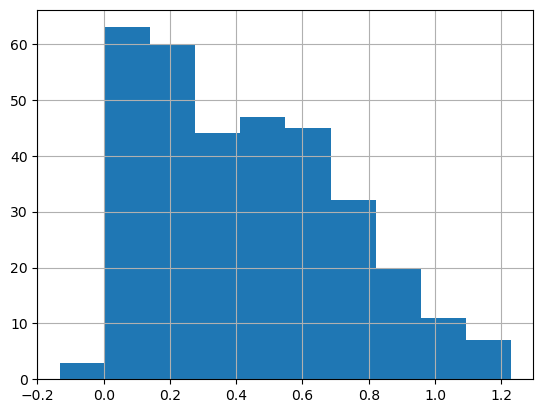

In [46]:
test.Survived_pred.hist();

In [47]:
test.Survived_pred.mean()

0.4379399037518624

Deriving the survived-column, let's just say that any value greater than 0.5 means survived.

In [48]:
test['Survived'] = [ 1 if element > 0.5 else 0 for element in preds.squeeze()]

In [49]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Parch_5,Parch_9,Embarked_Q,Embarked_S,Embarked_C,Log_Age,Log_Fare,Ones,Survived_pred,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,1,0,0,0.453947,0.893717,1,0.340303,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,1,0,0.618421,0.845098,1,0.461622,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,1,0,0,0.815789,0.986212,1,0.387979,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,1,0,0.355263,0.937643,1,0.114024,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,1,0,0.289474,1.089464,1,0.510544,1


Creating a new dataframe with just the columns `PassengerId` and `Survived` (as requested for the submission of the results):

In [50]:
test[['PassengerId', 'Survived']].head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [51]:
submission = test[['PassengerId', 'Survived']]

In [52]:
submission.to_csv('submission.csv', index=False)

I uploaded the results, and the result is unbelievably good: **Score: 0.75837**

One more attempt: Let's set the threshold to 0.6:

In [53]:
test['Survived'] = [ 1 if element > 0.6 else 0 for element in preds.squeeze()]
submission4 = test[['PassengerId', 'Survived']]
submission4.to_csv('submission4.csv', index=False)

The score went down: **Score: 0.72727** (I somehow expected that looking at the histogram.)

## Step 5: Re-do with 3 layers of parameters

I initially coded it with 2 layers, if you want to get the 2 layer version, feel free to remove the 3rd layer.

In [54]:
def create_layer():
    layer = torch.rand(20, dtype=torch.float64)-0.5 #https://pytorch.org/docs/stable/generated/torch.rand.html
    layer.requires_grad_()
    return layer

layer1 = create_layer()
layer2 = create_layer()
layer3 = create_layer()

In [55]:
layer1

tensor([-0.2657,  0.4991, -0.3225,  0.1319,  0.1734,  0.2937,  0.1468,  0.0825,
        -0.0401,  0.2960,  0.4038,  0.4735,  0.1428, -0.1275, -0.2948, -0.4493,
        -0.0552,  0.0775,  0.2237,  0.0927], dtype=torch.float64,
       requires_grad=True)

In [56]:
layer2

tensor([-0.1783,  0.1441, -0.2199,  0.4132, -0.4671, -0.0144,  0.4927,  0.0895,
        -0.2389,  0.4413, -0.3629,  0.3726,  0.0590,  0.3451, -0.3747,  0.4434,
        -0.4538, -0.2640, -0.4761,  0.3950], dtype=torch.float64,
       requires_grad=True)

In [57]:
layer3

tensor([ 0.2419,  0.4471,  0.1690, -0.3446, -0.4179,  0.2309,  0.2764,  0.4769,
        -0.4804, -0.4616, -0.0706, -0.1562,  0.0494,  0.3238,  0.4845,  0.1826,
         0.4001, -0.1978,  0.2509, -0.4074], dtype=torch.float64,
       requires_grad=True)

The optimizer essentially contains the same steps as above.

True, I could have done a better job at shortening the code, but I think this way it is more explicit what is happening, and it is easy to comment the 3rd layer.

In [58]:
def run_optimizer2_step(layer1, layer2, layer3, lr=0.01):
    preds1 = train_tensor@layer1
    preds1 = preds1.relu()
    preds2 = train_tensor@layer2
    preds2 = preds2.relu()
    preds3 = train_tensor@layer3
    preds3 = preds3.relu()
    preds = preds1 + preds2
    preds += preds3
    loss = ((preds-survived_tensor)**2).mean()
    
    layer1.grad = None #Initializing gradients (.zero_grad())
    layer2.grad = None #Initializing gradients (.zero_grad())
    layer3.grad = None #Initializing gradients (.zero_grad())
    
    loss.backward() #Calculate gradients
    with torch.no_grad():
        layer1 -= layer1.grad*lr #update parameters
        layer2 -= layer2.grad*lr #update parameters
        layer3 -= layer3.grad*lr #update parameters
    
    return loss   

Let's run the optimizer:

In [59]:
for i in range(25):
    loss = run_optimizer2_step(layer1, layer2, layer3, lr=0.1)
    print(f"Loss: {loss:.2f}")

Loss: 0.27
Loss: 0.19
Loss: 0.19
Loss: 0.19
Loss: 0.18
Loss: 0.18
Loss: 0.18
Loss: 0.18
Loss: 0.18
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.17
Loss: 0.16


As a result, we now have new parameters, we can apply to the test data.

## Step 6: Re-do Predictions with new model

Let's recover the test data:

In [60]:
test = test_save.copy()
test2 = test2_save.copy()

In [61]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [62]:
test2.head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Embarked_C,Embarked_Q,Log_Age,Log_Fare,Ones
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.453947,0.893717,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.618421,0.845098,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.815789,0.986212,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.355263,0.937643,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.289474,1.089464,1


This is the forward pass to do get the predictions:

In [63]:
preds1 = test_tensor@layer1
preds1 = preds1.relu()
preds2 = test_tensor@layer2
preds2 = preds2.relu()
preds3 = test_tensor@layer3
preds3 = preds3.relu()
preds = preds1 + preds2
preds += preds3

test['Survived_pred'] = preds.detach().numpy()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.250963
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.620510
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.219481
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.097688
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.639145


This time, we get 2 separate areas in the histogram which separate survived and not survived:

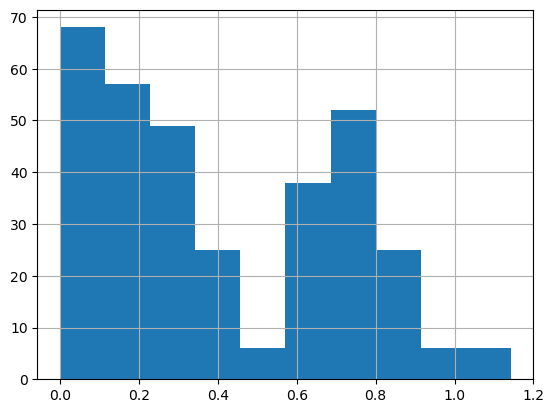

In [64]:
test.Survived_pred.hist();

In [65]:
test.Survived_pred.mean()

0.41907883962730547

Creating the survived column:

In [66]:
test['Survived'] = [ 1 if element > 0.5 else 0 for element in preds.squeeze()]
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_pred,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.250963,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.620510,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.219481,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.097688,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.639145,1


Creating the submission file:

In [67]:
submission = test[['PassengerId', 'Survived']]
submission.to_csv('submission-3layers.csv', index=False)

What can I say, a new High Score:
* **Score: 0.77033** (2-layers)
* **Score: 0.77272** (3-layers)

![score077272](score077272.png)

It is quite surprising: The self-written algorithm is better than the Fast.AI one...

Nonetheless it seems to hit a ceiling.

I see additional ways to optimize this, for example, the layers are actually not a neural net, because they do not feed into each other, but they are in parallel.

But my goal is not to optimize competition, but to participate in my first kaggle competition, and to re-visit the topic of gradient descent.

I will sure return to this dataset, but that is for another time.